# **Titanic Survival Prediction**


<div style="background-color: whitesmoke; padding: 30px; padding-top: 10px;">
    <h2>Table of Contents</h2>
    <div><a href="#S1">1. Introduction</a></div>
    <div><a href="#S2">2. Load and Inspect Data</a></div>
    <div><a href="#S3">3. Feature Engineering</a></div>
    <div><a href="#S4">4. Fill Missing Values</a></div>
    <div><a href="#S5">5. Prepare Data for Training and Testing</a></div>
    <div><a href="#S6">6. Model Pipelines</a></div>
    <div><a href="#S7">7. Train the Models</a></div>
    <div><a href="#S8">8. Model Prediction and Evaluation (Validation Set)</a></div>
    <div><a href="#S9">9. Model Prediction (Test Set)</a></div>
</div>

<a id="S1"></a>
## 1. Introduction 


April 15, 1912: The air is frigid, the sea a chaos. Aboard the RMS Titanic, disaster strikes. Can you defy history and survive?

This analysis constructs a classification model to predict passenger survival in the Titanic's sinking. Our goals are to build a high-performing predictive model and to analyse the passenger characteristics most influential in survival. We aim to uncover patterns within this tragic event.

This analysis follows the typical data science process: data loading and cleaning, feature engineering, model training, and final model evaluation and prediction.

For this analysis, the datasets provided as part of the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview) Kaggle competition will be used.

(This analysis was completed as part of the [IBM Machine Learning with Python course](https://www.coursera.org/learn/machine-learning-with-python/home/module/6)).


### Skills

- Python
- Data wrangling
- Feature engineering
- Binary classification
- Model pipelines
- Hyperparameter tuning (parameter grid search)
- Model training and evaluation

### Tools
 - numpy
 - pandas
 - seaborn
 - matplotlib
 - scikit-learn
   - LogisticRegression
   - RandomForestClassifier
   - XGBClassifier
   - preprocessing (StandardScaler, OneHotEncoder, IterativeImputer)
   - construct model pipeline (Pipeline)
   - cross validation (StratifiedKFold)
   - hyperparameter tuning (GridSearchCV)
   - model evaluation (classification_report, confusion_matrix, ConfusionMatrixDisplay, feature importances, feature coefficients)


### Install and import libraries

In [1]:
# !pip -q install numpy
# !pip -q install matplotlib
# !pip -q install pandas
# !pip -q install scikit-learn
# !pip -q install seaborn;
# !pip -q install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import re

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

<a id="S2"></a>
## 2. Load and Inspect Data

This analysis uses the Titanic passenger dataset to predict survival. In this section, we load the dataset and perform initial exploratory data analysis to understand its structure and identify any potential issues.

The target variable, `Survived`, is binary: 1 indicates survival, and 0 indicates non-survival. The dataset includes 14 features, which will be used as predictors in our model. The dataset is included in the seaborn library.

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |Survived | TARGET, Did the passenger survive?, 0 = No, 1 = Yes  |
 |PassengerId| Unique identification number |
 |Pclass | A proxy for socio-economic status (SES), 1 = Upper, 2 = Middle, 3 = Lower |
 |Name   | Passenger name including title |
 |Sex	 |sex |
 |Age	 | age in years  |
 |Sibsp  |	# of siblings / spouses aboard the Titanic |
 |Parch  |	# of parents / children aboard the Titanic, some children travelled only with a nanny, therefore parch=0 for them|
 |Ticket | ticket number |
 |Fare   |	Passenger fare   |
 |Cabin  | cabin number |
 |Embarked | Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton |


### Load data

We load the training and test datasets using pandas. These datasets were downloaded from the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview) Kaggle competition. The training set will be used to build and evaluate our predictive models. For the test set, the target feature `survived` is not provided, and it is therfore used to obtain a final independent score through the Kaggle competition submition without the risk of data leakage. 

In [3]:
# titanic = sns.load_dataset('titanic')
# Load data from CSV file into a DataFrame
titanic_train = pd.read_csv('titanic_train.csv') 
titanic_test = pd.read_csv('titanic_test.csv')

train_len = titanic_train.shape[0]

titanic = pd.concat([titanic_train, titanic_test], sort=True).reset_index(drop=True)

### Data overview

To begin with, let's get an overview of the data. 

In [4]:
def print_overview(df):
    
    print(f"{df.shape[0]} entries, {df.shape[1]} columns \n")
    print(f"{'Column':<15} | {'Data Type':<10} | {'Nulls':<5} | Unique Values/Range")
    print("-" * 70)  # Separator line
    for column in df.columns:
        unique_values = df[column].unique()
        data_type = df[column].dtype
        null_count = df[column].isnull().sum()

        print(f"{column:<15} | {str(data_type):<10} | {null_count:<5} | ", end="")

        if pd.api.types.is_numeric_dtype(data_type):
            if pd.api.types.is_bool_dtype(data_type): #check if bool
                print(*unique_values, sep=", ") #print the bool values
            else:
                min_val = df[column].min()
                max_val = df[column].max()
                print(f"{min_val}-{max_val}")
        else:
            if len(unique_values)>10:
                print(f'# of unique values: {len(unique_values)}')
            else:
                print(*unique_values, sep=", ") #unpack the array
    

print('Training data:\n')
print_overview(titanic_train)
print('\nTest data:\n')
print_overview(titanic_test)

Training data:

891 entries, 12 columns 

Column          | Data Type  | Nulls | Unique Values/Range
----------------------------------------------------------------------
PassengerId     | int64      | 0     | 1-891
Survived        | int64      | 0     | 0-1
Pclass          | int64      | 0     | 1-3
Name            | object     | 0     | # of unique values: 891
Sex             | object     | 0     | male, female
Age             | float64    | 177   | 0.42-80.0
SibSp           | int64      | 0     | 0-8
Parch           | int64      | 0     | 0-6
Ticket          | object     | 0     | # of unique values: 681
Fare            | float64    | 0     | 0.0-512.3292
Cabin           | object     | 687   | # of unique values: 148
Embarked        | object     | 2     | S, C, Q, nan

Test data:

418 entries, 11 columns 

Column          | Data Type  | Nulls | Unique Values/Range
----------------------------------------------------------------------
PassengerId     | int64      | 0     | 892-1309


**At first glance, the following observations can be made:**

1. The target (`Survived`) is binary and complete.
2. The `PassengerId` numbers are random and unique to each entry and it can therefore be assumed that it has no outcome on the target. All other features are potential predictors.
3. 4 out of 10 predictors are incomplete (`Age`, `Fare`, `Cabin` and `Embarked`). 
4. 5 predictors are numeric, 5 predictors are categorical.

The describe() method provides a statistical summary of the data, including measures of central tendency, dispersion, and count for both numerical and categorical columns. This helps us quickly grasp the distribution of values and identify potential outliers.

In [5]:
print('\nStatistical summary of training and test sets combined: \n')
titanic.describe(include = 'all')


Statistical summary of training and test sets combined: 



,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [6]:
print('\nSmall sample of the training set: \n')
titanic.sample(5)


Small sample of the training set: 



,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
220,16.0,NaN,S,8.0500,"Sunderland, Mr. Victor Francis",0,221,3,male,0,1.0,SOTON/OQ 392089
1261,21.0,NaN,S,11.5000,"Giles, Mr. Edgar",0,1262,2,male,1,NaN,28133
533,NaN,NaN,C,22.3583,"Peter, Mrs. Catherine (Catherine Rizk)",2,534,3,female,0,1.0,2668
404,20.0,NaN,S,8.6625,"Oreskovic, Miss. Marija",0,405,3,female,0,0.0,315096
715,19.0,F G73,S,7.6500,"Soholt, Mr. Peter Andreas Lauritz Andersen",0,716,3,male,0,0.0,348124


<a id="S3"></a>
## 3. Feature Engineering

Feature engineering involves creating new features from existing ones to potentially improve the predictive power of our models. In this section, we'll derive several new features that capture potentially relevant information from the Titanic data.

### Deck

The `Cabin` feature includes a letter indicating the deck and a number specifying the cabin's location. We can extract the deck letter to create a new `Deck` feature. Deck location might be a significant predictor of survival, as access to lifeboats could have varied between decks. However, the `Cabin` feature has many missing values (1014 out of 1309). To address this, we'll assign 'X' to the `Deck` feature for passengers with unknown cabin locations.

In [7]:
def extract_deck(cabin):
    if pd.isna(cabin):
        return 'X'
    match = re.search(r'[a-zA-Z]', cabin)
    if match:
        return match.group(0)
    else:
        return 'X'

titanic['Deck'] = titanic['Cabin'].apply(extract_deck)
titanic.sample(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
716,38.0,C45,C,227.525,"Endres, Miss. Caroline Louise",0,717,1,female,0,1.0,PC 17757,C
825,NaN,NaN,Q,6.950,"Flynn, Mr. John",0,826,3,male,0,0.0,368323,X
927,NaN,NaN,S,8.050,"Roth, Miss. Sarah A",0,928,3,female,0,NaN,342712,X


### Family size

The `SibSp` and `Parch` columns indicate the number of siblings/spouses and parents/children traveling with each passenger, respectively. We propose that family size could be a significant factor in survival. On one hand, having more relatives might offer a survival advantage through coordinated efforts and mutual support during an emergency. Conversely, larger families might face challenges in evacuating together, potentially lowering the survival rate of individual members. To investigate this potential relationship, we derive a new feature, `FamilySize`, representing the total number of family members.

In [8]:
titanic['FamilySize'] = titanic.SibSp + titanic.Parch + 1 # +1 to include the individual themselves
titanic.sample(2)
print(f'Family size ranges from {titanic.FamilySize.min()} to {titanic.FamilySize.max()}')

Family size ranges from 1 to 11


### Ticket

The `Ticket` feature presents a challenge due to its high cardinality, with 929 unique values out of 1309 total. Including so many unique categories in a classification model can lead to overfitting and decreased generalization. To address this, we engineer a `Ticket_Frequency` feature. This feature counts how many passengers are associated with each ticket number, providing a measure of group travel. We assume that passengers sharing a ticket were likely traveling companions, potentially influencing their survival probabilities in a manner similar to family groups.

Preliminary examination of the data reveals that `Ticket` values often group passengers with the same last name, supporting the idea that families purchased tickets together. However, it's important to recognise that shared tickets may also link individuals with non-familial relationships, such as friendships, more distant kinship, or employer-employee connections, which are not accounted for in the `SibSp` and `Parch` variables.

In [9]:
titanic['Ticket_Frequency'] = titanic.groupby('Ticket')['Ticket'].transform('count')
print(f'Ticket frequency ranges from {titanic.Ticket_Frequency.min()} to {titanic.Ticket_Frequency.max()}')

Ticket frequency ranges from 1 to 11


### Last name and title

Passenger names are recorded in the `Name` feature as: '[Last Name], [Title]. [First Name]'. Although the complete name is unique to each individual and therefore unlikely to be predictive, the title and last name components offer potentially relevant information:

- **Title:** Could provide insights into a passenger's age, marital status, and socioeconomic class.
- **Last name:** Allows us to identify potential family connections among passengers.

In [10]:
def extract_name_title(name_title):
    if pd.isna(name_title):
      return None
    match = re.search(r'([^,]+), ([^.]+)\.?', str(name_title))
    return pd.Series([match.group(1).strip(), match.group(2).strip()])
    
titanic[['LastName', 'Title']] = titanic['Name'].apply(extract_name_title)
# print(titanic['Title'].value_counts())
# print(titanic['LastName'].value_counts())
titanic.sample(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,FamilySize,Ticket_Frequency,LastName,Title
578,NaN,NaN,C,14.4583,"Caram, Mrs. Joseph (Maria Elias)",0,579,3,female,1,0.0,2689,X,2,2,Caram,Mrs
1087,6.0,E34,C,134.5000,"Spedden, Master. Robert Douglas",2,1088,1,male,0,NaN,16966,E,3,5,Spedden,Master


In [11]:
titanic['Title'] = titanic['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
print(titanic['Title'].value_counts())

Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64


Although we've already created `FamilySize` and `Ticket_Frequency` to represent group connections, we'll engineer an additional feature, `LastName_Frequency`, using the extracted last names. While expected to be highly correlated with `FamilySize`, comparing all three features will provide further insight into the relationship between group affiliation and survival.

In [12]:
titanic['LastName_Frequency'] = titanic.groupby('LastName')['LastName'].transform('count')
print(f'Last name frequency ranges from {titanic.LastName_Frequency.min()} to {titanic.LastName_Frequency.max()}')

Last name frequency ranges from 1 to 11


### Comparing FamilySize, Ticket_Frequency and LastName_Frequency

Now, let's compare the newly created `FamilySize`, `Ticket_Frequency`, and `LastName_Frequency` features to see how they relate to survival rates. We hypothesize that these features might be correlated, as they all capture information about group affiliation.

#### Survival rate scatter plot

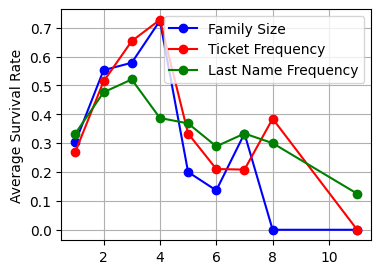

In [13]:
# Group by family size
avg_survival_FamilySize = titanic.groupby('FamilySize')['Survived'].mean().reset_index()
# Group by ticket frequency
avg_survival_Ticket_Frequency = titanic.groupby('Ticket_Frequency')['Survived'].mean().reset_index()
# Group by last name frequency
avg_survival_LastName_Frequency = titanic.groupby('LastName_Frequency')['Survived'].mean().reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(avg_survival_FamilySize.FamilySize, avg_survival_FamilySize.Survived, marker='o', linestyle='-', color='blue', label='Family Size')
plt.plot(avg_survival_Ticket_Frequency.Ticket_Frequency, avg_survival_Ticket_Frequency.Survived, marker='o', linestyle='-',color='red', label='Ticket Frequency')
plt.plot(avg_survival_LastName_Frequency.LastName_Frequency, avg_survival_LastName_Frequency.Survived, marker='o', linestyle='-',color='green', label='Last Name Frequency')

plt.legend()  # Show the legend
# plt.xlabel('Family Size')
plt.ylabel('Average Survival Rate')

plt.grid(True) # adds a grid to the graph.
plt.show()

The plot shows the average survival rate for different family sizes, ticket frequencies, and last name frequencies. We can see that survival rates tend to be higher for smaller group sizes (2-4) but drop significantly for larger groups.

#### Correlation map

<Axes: >

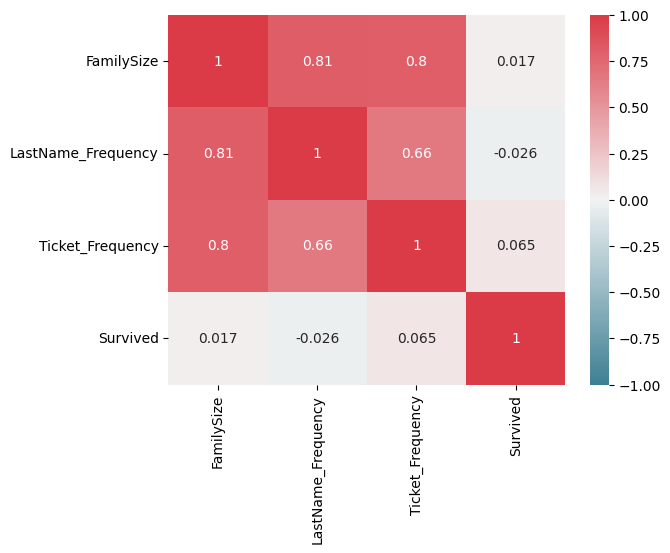

In [14]:
correlation_matrix = titanic[['FamilySize','LastName_Frequency','Ticket_Frequency','Survived']].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(correlation_matrix, cmap = colormap, annot=True, vmin=-1, vmax=1)

The correlation matrix shows a strong positive correlation (0.81) between `FamilySize` and `LastName_Frequency`, indicating that passengers with larger families were likely to share the same last name. `Ticket_Frequency` is also positively correlated with these features, suggesting that family members often traveled with the same ticket.

### Group survival rate 
<a id="Group-survival-rate"></a>

To incorporate potential group survival patterns, we define a custom transformer, `Group_Survival`, which will be implemented within the model pipeline. This transformer calculates survival statistics based on passenger last names and ticket numbers. Specifically, it computes the number of survivors sharing the same last name (`GroupSurvival_LastName`) and the number of survivors sharing the same ticket (`GroupSurvival_Ticket`).

It's critical to perform this calculation within the model pipeline, rather than as a preprocessing step before splitting the data into training and validation sets. Calculating these group survival statistics before the split would introduce data leakage. If we calculate group survival on the entire dataset before splitting, the validation set would contain information derived from the training set (i.e., the overall survival rates of those groups). This would artificially inflate the validation performance, as the model would "cheat" by having access to information it shouldn't have during evaluation. By performing the group survival calculation within the pipeline's fit method, we ensure that the `lastname_survival` and `ticket_survival` dictionaries are calculated only on the training data during the training phase.

In [15]:
class Group_Survival(BaseEstimator, TransformerMixin):
    def __init__(self, lastname_col='LastName', ticket_col='Ticket', survived_col='Survived'):
        self.lastname_col = lastname_col
        self.survived_col = survived_col
        self.ticket_col = ticket_col
        self.lastname_survival = {}  # Store last name survival counts
        self.ticket_survival = {}    # Store ticket survival counts

    def fit(self, X, y=None):
        train_df = X.copy()
        if self.survived_col in train_df.columns:
            self.lastname_survival = train_df.groupby(self.lastname_col)[self.survived_col].sum().to_dict()
            self.ticket_survival = train_df.groupby(self.ticket_col)[self.survived_col].sum().to_dict()
        return self

    def transform(self, X):
        test_df = X.copy()

        test_df['GroupSurvival_LastName'] = test_df[self.lastname_col].map(self.lastname_survival)
        if self.survived_col in test_df.columns:
            test_df['GroupSurvival_LastName'] = test_df['GroupSurvival_LastName'] - test_df[self.survived_col]
        test_df['GroupSurvival_LastName'] = test_df['GroupSurvival_LastName'].fillna(0)


        test_df['GroupSurvival_Ticket'] = test_df[self.ticket_col].map(self.ticket_survival)
        if self.survived_col in test_df.columns:
            test_df['GroupSurvival_Ticket'] = test_df['GroupSurvival_Ticket'] - test_df[self.survived_col]
        test_df['GroupSurvival_Ticket'] = test_df['GroupSurvival_Ticket'].fillna(0)

        return test_df.drop([self.lastname_col, self.ticket_col, self.survived_col], axis=1)

<a id="S4"></a>
## 4. Fill Missing Values

In this section, we address the following missing values in the dataset. Handling missing data is crucial to ensure that our models can process the data correctly and avoid introducing bias.

In [16]:
missing_vals=titanic.isnull().sum()
missing_vals[(missing_vals > 0) & (missing_vals.index != 'Survived')]

Age          263
Cabin       1014
Embarked       2
Fare           1
dtype: int64

### Embarked

Given that the `Embarked` feature has only two missing values, it's practical to investigate these specific cases. We can research the passengers associated with these missing values to determine their port of embarkation. This targeted approach allows us to fill in the missing data with accurate information, rather than resorting to a more general imputation strategy that might introduce inaccuracies.

In [17]:
titanic[titanic.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,FamilySize,Ticket_Frequency,LastName,Title,LastName_Frequency
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,B,1,2,Icard,Miss,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,B,1,2,Stone,Mrs,1


From Martha Evelyn Stone: Titanic Survivor: "Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28."

We will therefore fill the missing values with 'S'.

In [18]:
titanic.Embarked = titanic.Embarked.fillna('S')

### Fare

The `Fare` feature has a single missing value. We first investigate whether any other passengers share the same ticket number, as fares are often consistent within traveling groups. However, it appears this passenger traveled alone. Therefore, we defer handling this missing value to the imputation step within our model pipeline.

In [19]:
titanic[titanic.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,FamilySize,Ticket_Frequency,LastName,Title,LastName_Frequency
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,X,1,1,Storey,Mr,1


### Other

Missing values remain in the `Age` and `Cabin` features.

For the `Age` feature, given the substantial number of missing entries, we will employ scikit-learn's IterativeImputer within our model pipeline. This multivariate imputation technique estimates missing values using the relationships between different features.

Rather than using the `Cabin` feature directly, we performed feature engineering to create a `Deck` feature. Passengers lacking cabin information were assigned to the 'X' category in this derived feature.

<a id="S5"></a>
## 5. Prepare Data for Training and Testing


Now, we prepare the data for machine learning. This involves selecting the features we'll use to train our models, defining the target variable, and splitting the data into training and validation sets.

### Predictors and target


We define `Survived` as our target variable (y), which is what we want to predict. The remaining columns in X will be used as predictor variables.

We drop `PassengerId` because it's a unique identifier, `Cabin` because it has too many missing values and we've extracted `Deck`, and `Name` because we've extracted title and last name. Importantly, `Ticket`, `LastName`, and `Survived` are retained temporarily and will be dropped within the model pipeline (prior to training) once they've served their purpose in calculating the [group survival rate](#Group-survival-rate).

In [20]:
target = 'Survived'
drop_features= ['PassengerId', 'Cabin', 'Name','LastName_Frequency','SibSp','Parch'] 

titanic_train = titanic.loc[:train_len-1]
titanic_test = titanic.loc[train_len:]

X = titanic_train.drop(drop_features, axis=1)
y = titanic_train[target]

PassengerId_test=titanic_test.PassengerId
X_test = titanic_test.drop(drop_features, axis=1)

X.sample(3)

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Deck,FamilySize,Ticket_Frequency,LastName,Title
255,29.0,C,15.2458,3,female,1.0,2650,X,3,3,Touma,Mrs
641,24.0,C,69.3000,1,female,1.0,PC 17477,B,1,2,Sagesser,Miss
433,17.0,S,7.1250,3,male,0.0,STON/O 2. 3101274,X,1,1,Kallio,Mr


### Are the classes balanced?

It's important to check the class distribution of the target variable. An imbalanced dataset (where one class is much more frequent than the other) can bias our models. We see that about 38% of the passengers in the training set survived, indicating a slight class imbalance, and therefore we should stratify the data when performing train/test spint and for cross-validation.

In [21]:
target_proportions=y.value_counts()

print(target_proportions)
print(f"{round((target_proportions[1]/target_proportions.sum())*100,2)}% of the passengers survived.")

Survived
0.0    549
1.0    342
Name: count, dtype: int64
38.38% of the passengers survived.


### Split data into training/test sets

We split the data into training and validation sets. The training set is used to train the models, and the validation set is used to evaluate their performance on unseen data. We use stratified sampling to maintain the proportion of survival classes in both sets.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<a id="S6"></a>
## 6. Model Pipelines

Machine learning pipelines streamline the process of preprocessing and modeling. We define pipelines to handle numerical and categorical features, and then train several different classification models.

### Pre-processing transformers 

In [23]:
#Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist() + ['GroupSurvival_LastName','GroupSurvival_Ticket']
numerical_features.remove('Survived')
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features.remove('LastName')
categorical_features.remove('Ticket')

We create separate preprocessing pipelines for numerical and categorical features. Numerical features are imputed using iterative imputation (missing `age` and `fare` values) and then scaled. Categorical features are one-hot encoded.

In [24]:
# Define separate preprocessing pipelines for both feature types
numerical_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer()), #fill missing values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

The sklearn "column transformer" transforms the numerical and categorical features separately and then concatenates the output as a single feature space, ready for input to a machine learning estimator.


In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Next, we define pipelines for Logistic Regression, Random Forest, and XGBoost. Each pipeline includes the 'Related_Survival' transformer, the preprocessing steps, and the classification model.

### Logistic regression pipeline

In [26]:
pipeline_LR = Pipeline(steps=[
    ('Group_Survival', Group_Survival()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

### Random forest pipeline

In [27]:
pipeline_RF = Pipeline(steps=[
    ('Group_Survival', Group_Survival()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### XGBoost pipeline

In [28]:
pipeline_XGB = Pipeline(steps=[
    ('Group_Survival', Group_Survival()),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

<a id="S7"></a>
## 7. Train the Models

In this section, we train our machine learning models using cross-validation to find the best hyperparameters. Hyperparameters are settings of the model that we tune to optimise performance.

### Parameter grid 
We'll use the grid in a cross validation search to optimise the model


In [29]:
# Logistic Regression
param_grid_LR = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

# Random Forest
param_grid_RF = {
    'classifier__n_estimators': [1000, 1200, 1400, 1600],
    'classifier__max_depth': [12, 14, 16, 18],
    'classifier__min_samples_split': [1, 2, 3, 4, 5],
    'classifier__min_samples_leaf': [1, 2, 3]
}

#XGBoost
param_grid_XGB = {
    'classifier__n_estimator' :[1500, 1750, 2000],
    'classifier__max_depth': [2, 4, 6, 8],
    'classifier__learning_rate': [0.03, 0.04, 0.05, 0.06]
}

### Cross-validation method

We use stratified k-fold cross-validation (with k=5) to evaluate the model's performance. Stratified k-fold ensures that each fold has a similar proportion of survival classes as the original dataset. Shuffling the data helps to reduce the risk of ordering bias.

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

### Train the pipeline model 
GridSearchCV systematically searches through all combinations of hyperparameters in the parameter grid to find the combination that yields the best performance on the cross-validation sets. The best_params_ attribute of the GridSearchCV object gives us the optimal hyperparameters found during the search.

In [31]:
model_LR = GridSearchCV(estimator=pipeline_LR, param_grid=param_grid_LR, cv=cv, scoring='accuracy', verbose=0)
model_LR.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Group_Survival', Group_Survival()),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Pclass',
                                                                          'FamilySize',
                                                                          'Ticket_Frequency',
                                                                          'GroupSurvival_LastName',
                                                                          'GroupSurvival_Ticket']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Embarked',
                                                                          'Sex',
                                                                          'Deck',
                                                                          'Title'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='accuracy')

In [32]:
best_hyperparameters_LR = model_LR.best_params_
print(best_hyperparameters_LR)

{'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [33]:
model_RF = GridSearchCV(estimator=pipeline_RF, param_grid=param_grid_RF, cv=cv, scoring='accuracy', verbose=0)
model_RF.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Group_Survival', Group_Survival()),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Pclass',
                                                                          'FamilySize',
                                                                          'Ticket_Frequency',
                                                                          'GroupSurvival_LastName',
                                                                          '...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Embarked',
                                                                          'Sex',
                                                                          'Deck',
                                                                          'Title'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [12, 14, 16, 18],
                         'classifier__min_samples_leaf': [1, 2, 3],
                         'classifier__min_samples_split': [1, 2, 3, 4, 5],
                         'classifier__n_estimators': [1000, 1200, 1400, 1600]},
             scoring='accuracy')

In [34]:
best_hyperparameters_RF = model_RF.best_params_
print(best_hyperparameters_RF)

{'classifier__max_depth': 14, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 1600}


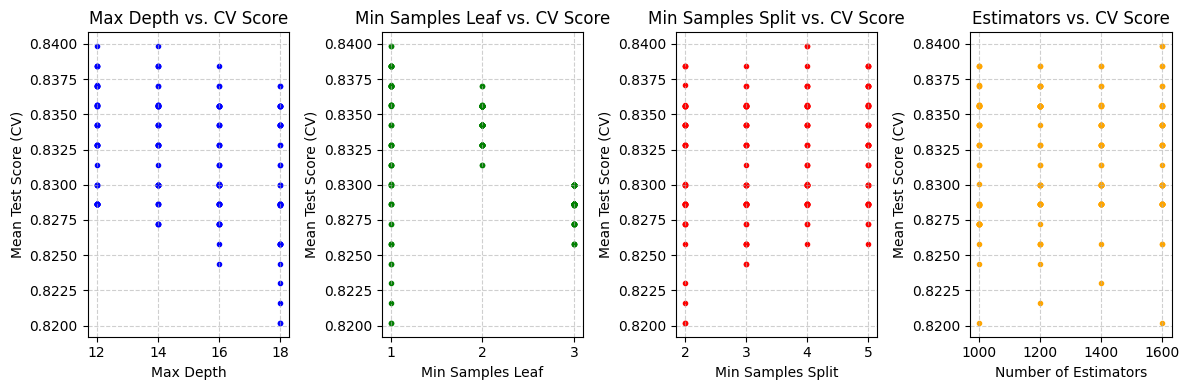

In [35]:
y_plot=model_RF.cv_results_['mean_test_score']
x_plot_max_depth=model_RF.cv_results_['param_classifier__max_depth']
x_plot_min_samples_leaf=model_RF.cv_results_['param_classifier__min_samples_leaf']
x_plot_min_samples_split=model_RF.cv_results_['param_classifier__min_samples_split']
x_plot_n_estimator=model_RF.cv_results_['param_classifier__n_estimators']

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # 1 row, 3 columns; adjust figsize as needed

# Plot 1: Max Depth vs. Mean Test Score
axes[0].scatter(x_plot_max_depth, y_plot, marker='.', color='blue')
axes[0].set_xlabel('Max Depth', fontsize=10)
axes[0].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[0].set_title('Max Depth vs. CV Score', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Min Samples Leaf vs. Mean Test Score
axes[1].scatter(x_plot_min_samples_leaf, y_plot, marker='.', color='green')
axes[1].set_xlabel('Min Samples Leaf', fontsize=10)
axes[1].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[1].set_title('Min Samples Leaf vs. CV Score', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Min Samples Split vs. Mean Test Score
axes[2].scatter(x_plot_min_samples_split, y_plot, marker='.', color='red')
axes[2].set_xlabel('Min Samples Split', fontsize=10)
axes[2].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[2].set_title('Min Samples Split vs. CV Score', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)

# Plot 4: Number of Estimators vs. Mean Test Score
axes[3].scatter(x_plot_n_estimator, y_plot, marker='.', color='orange')
axes[3].set_xlabel('Number of Estimators', fontsize=10)
axes[3].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[3].set_title('Estimators vs. CV Score', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

In [36]:
model_XGB = GridSearchCV(estimator=pipeline_XGB, param_grid=param_grid_XGB, cv=cv, scoring='accuracy', verbose=0)
model_XGB.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Group_Survival', Group_Survival()),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Pclass',
                                                                          'FamilySize',
                                                                          'Ticket_Frequency',
                                                                          'GroupSurvival_LastName',
                                                                          '...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'classifier__learning_rate': [0.03, 0.04, 0.05, 0.06],
                         'classifier__max_depth': [2, 4, 6, 8],
                         'classifier__n_estimator': [1500, 1750, 2000]},
             scoring='accuracy')

In [37]:
best_hyperparameters_XGB = model_XGB.best_params_
print(best_hyperparameters_XGB)

{'classifier__learning_rate': 0.06, 'classifier__max_depth': 4, 'classifier__n_estimator': 1500}


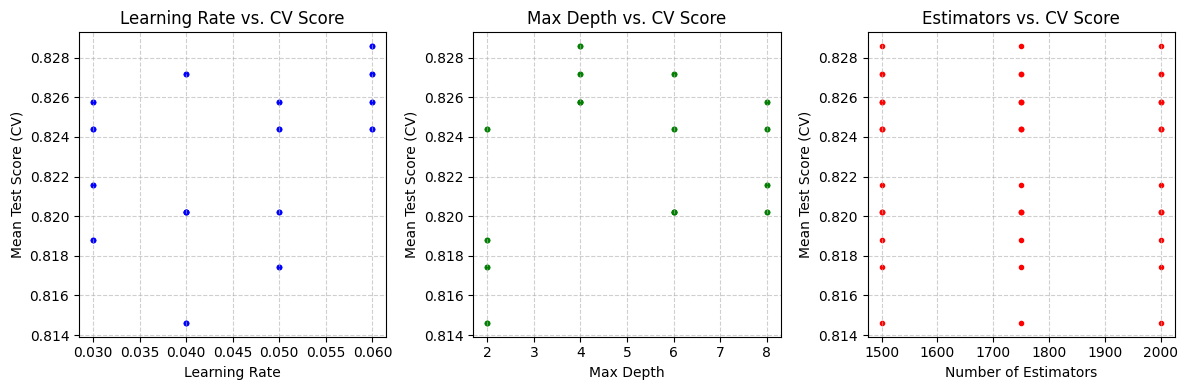

In [38]:
y_plot=model_XGB.cv_results_['mean_test_score']
x_plot_learning_rate=model_XGB.cv_results_['param_classifier__learning_rate']
x_plot_max_depth=model_XGB.cv_results_['param_classifier__max_depth']
x_plot_n_estimator=model_XGB.cv_results_['param_classifier__n_estimator']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns; adjust figsize as needed

# Plot 1: Learning Rate vs. Mean Test Score
axes[0].scatter(x_plot_learning_rate, y_plot, marker='.', color='blue')
axes[0].set_xlabel('Learning Rate', fontsize=10)
axes[0].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[0].set_title('Learning Rate vs. CV Score', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Max Depth vs. Mean Test Score
axes[1].scatter(x_plot_max_depth, y_plot, marker='.', color='green')
axes[1].set_xlabel('Max Depth', fontsize=10)
axes[1].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[1].set_title('Max Depth vs. CV Score', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Number of Estimators vs. Mean Test Score
axes[2].scatter(x_plot_n_estimator, y_plot, marker='.', color='red')
axes[2].set_xlabel('Number of Estimators', fontsize=10)
axes[2].set_ylabel('Mean Test Score (CV)', fontsize=10)
axes[2].set_title('Estimators vs. CV Score', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

<a id="S8"></a>
## 8. Model Prediction and Evaluation (Validation Set)

After training the models and finding the best hyperparameters, we evaluate their performance on the validation set. This gives us an estimate of how well the models are likely to perform on unseen data. We use the validation set, which was held out from the training data, to get an unbiased estimate of the model's performance. This helps us to avoid overfitting, where the model learns the training data too well and doesn't generalize well to new data.

In [39]:
y_pred_LR = model_LR.predict(X_val)
y_pred_RF = model_RF.predict(X_val)
y_pred_XGB = model_XGB.predict(X_val)

### Classification report
The classification report provides precision, recall, F1-score, and support for each class. Precision measures how often the model correctly predicts the positive class, recall measures how often the model correctly identifies all positive cases, and the F1-score is the harmonic mean of precision and recall.

In [40]:
print(f"Logistic Regression:\n{classification_report(y_val, y_pred_LR, digits=4)}\n")
print(f"Random Forest:\n{classification_report(y_val, y_pred_RF, digits=4)}\n")
print(f"XGBoost:\n{classification_report(y_val, y_pred_XGB, digits=4)}\n")

Logistic Regression:
              precision    recall  f1-score   support

         0.0     0.8019    0.7727    0.7870       110
         1.0     0.6575    0.6957    0.6761        69

    accuracy                         0.7430       179
   macro avg     0.7297    0.7342    0.7315       179
weighted avg     0.7462    0.7430    0.7443       179


Random Forest:
              precision    recall  f1-score   support

         0.0     0.8000    0.8364    0.8178       110
         1.0     0.7188    0.6667    0.6917        69

    accuracy                         0.7709       179
   macro avg     0.7594    0.7515    0.7548       179
weighted avg     0.7687    0.7709    0.7692       179


XGBoost:
              precision    recall  f1-score   support

         0.0     0.7787    0.8636    0.8190       110
         1.0     0.7368    0.6087    0.6667        69

    accuracy                         0.7654       179
   macro avg     0.7578    0.7362    0.7428       179
weighted avg     0.7626    

### Confusion matrix 
The confusion matrix shows the number of correct and incorrect predictions for each class. It helps us to visualize where the model is making mistakes.

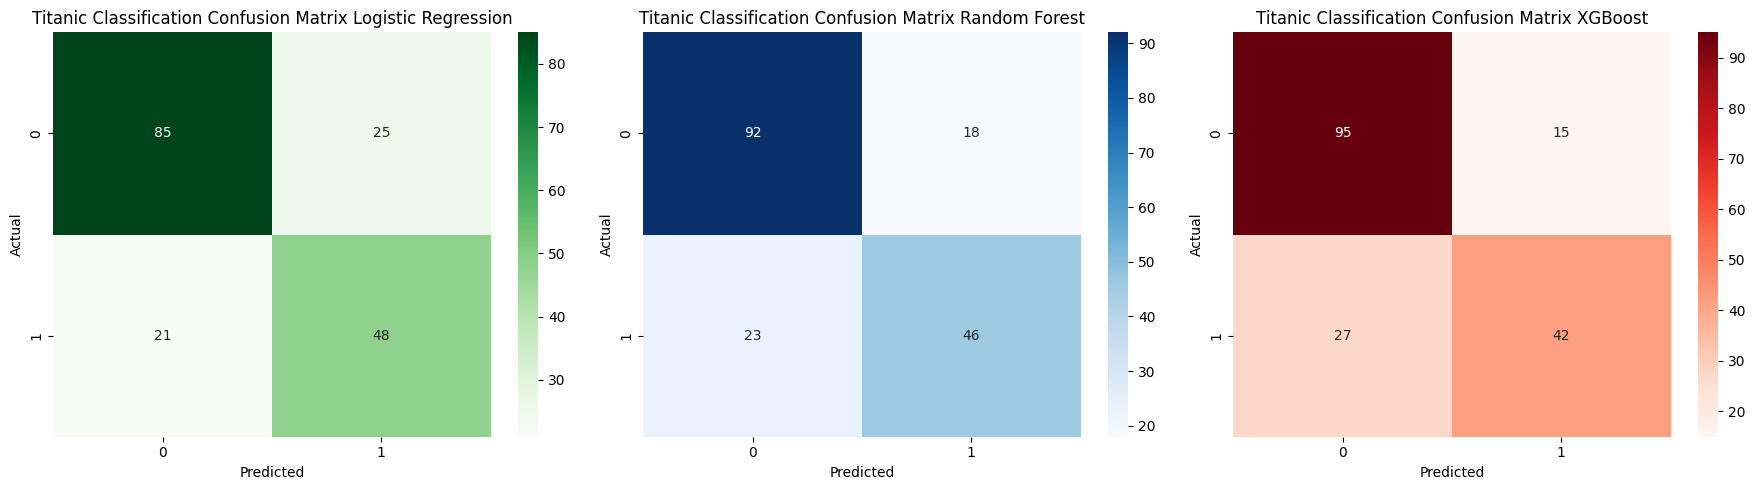

In [41]:
conf_matrix_LR = confusion_matrix(y_val, y_pred_LR)
conf_matrix_RF = confusion_matrix(y_val, y_pred_RF)
conf_matrix_XGB = confusion_matrix(y_val, y_pred_XGB)

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 2 columns

# Plot the heatmaps

sns.heatmap(conf_matrix_LR, annot=True, cmap='Greens', fmt='d', ax=axes[0])
axes[0].set_title('Titanic Classification Confusion Matrix Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_RF, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_title('Titanic Classification Confusion Matrix Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(conf_matrix_XGB, annot=True, cmap='Reds', fmt='d', ax=axes[2])
axes[2].set_title('Titanic Classification Confusion Matrix XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Feature importances / coefficients

Feature importances (for Random Forest and XGBoost) and coefficients (for Logistic Regression) indicate the relative importance of each feature in the model's predictions. This helps us to understand which factors were most influential in determining survival.

In [42]:
#Logistic Regression feature coefficients
feature_coefficients_LR = model_LR.best_estimator_.named_steps['classifier'].coef_[0]

# Combine the numerical and one-hot encoded categorical feature names
feature_names_LR = numerical_features + list(model_LR.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features))

# Random Forest feature importance
feature_importances_RF = model_RF.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names_RF = numerical_features + list(model_RF.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

# XGBoost feature importance
feature_importances_XGB = model_XGB.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names_XGB = numerical_features + list(model_XGB.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

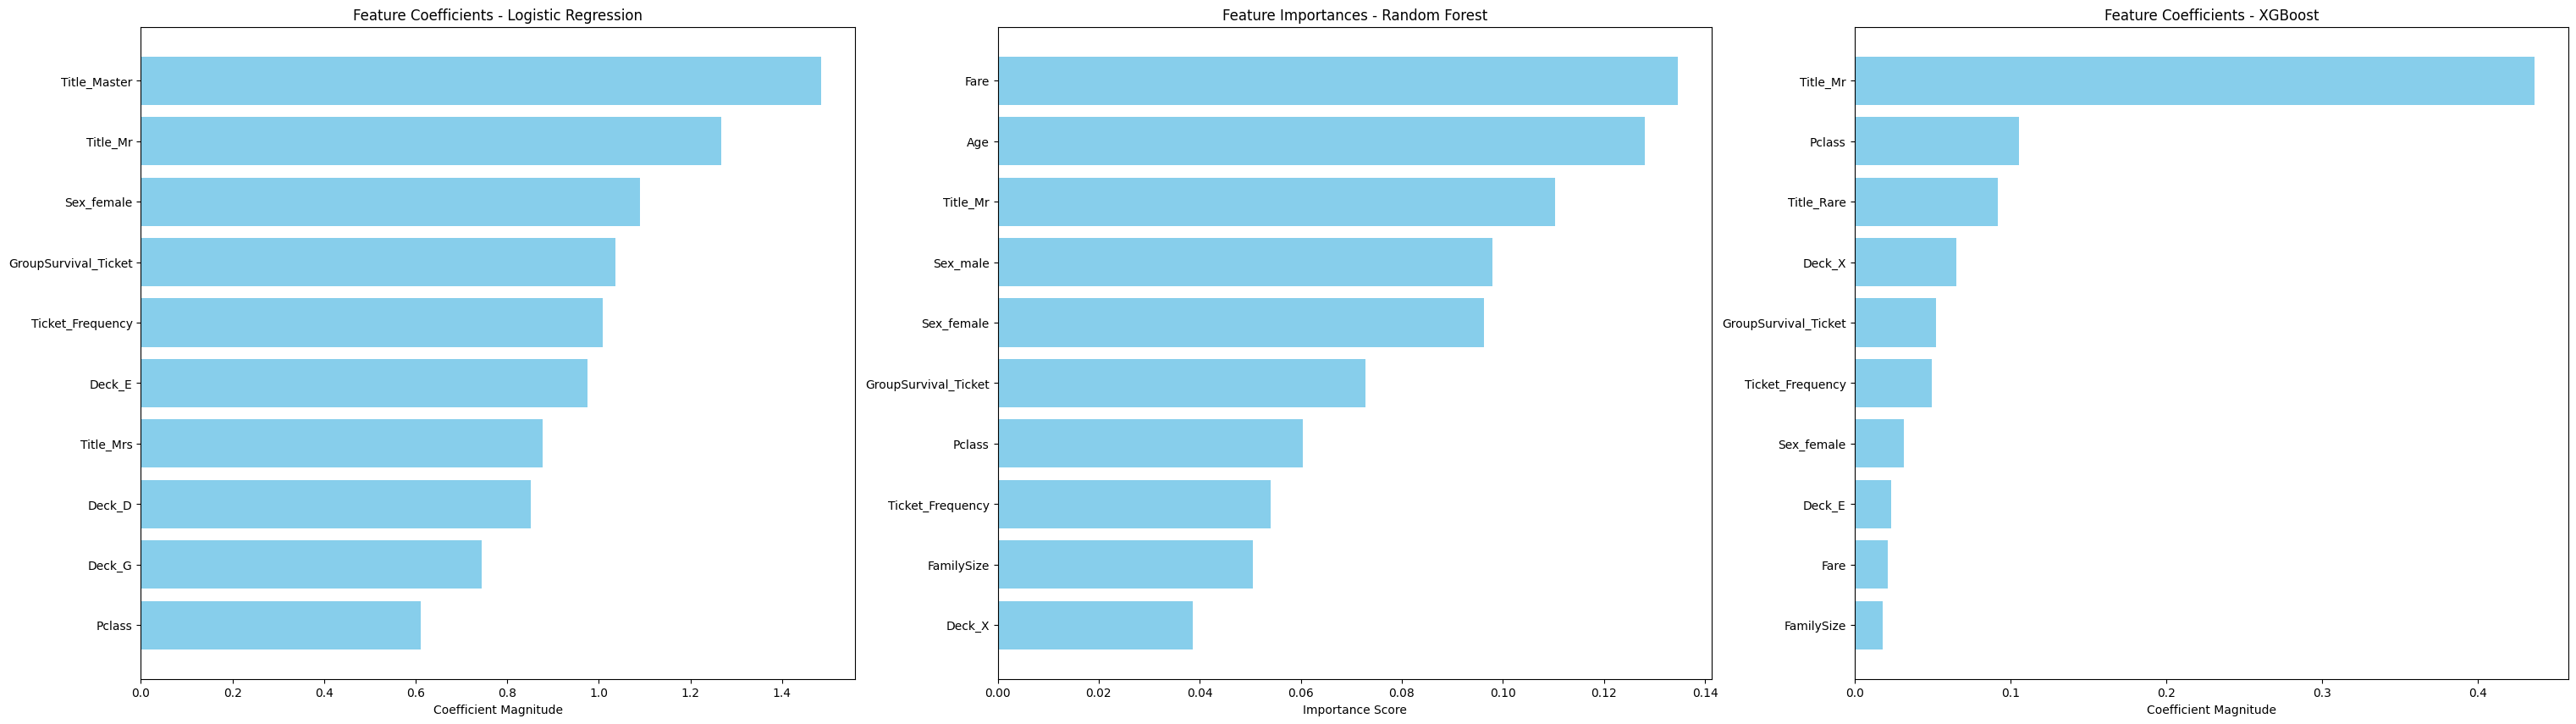


Logistic regression test set accuracy: 74.30%

Random forest test set accuracy: 77.09%

XGBoost test set accuracy: 76.54%


In [43]:
importance_LR_df = pd.DataFrame({'Feature': feature_names_LR,
                              'Coefficient': abs(feature_coefficients_LR)
                             }).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

importance_RF_df = pd.DataFrame({'Feature': feature_names_RF,
                              'Importance': feature_importances_RF
                             }).sort_values(by='Importance', ascending=False)

importance_XGB_df = pd.DataFrame({'Feature': feature_names_XGB,
                              'Importance': feature_importances_XGB
                             }).sort_values(by='Importance', ascending=False)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(37, 10))  # 1 row, 2 columns


#Plot the heat maps
axes[0].barh(importance_LR_df['Feature'][:10], importance_LR_df['Coefficient'][:10], color='skyblue')
axes[0].invert_yaxis()
axes[0].set_title('Feature Coefficients - Logistic Regression')
axes[0].set_xlabel('Coefficient Magnitude')

axes[1].barh(importance_RF_df['Feature'][:10], importance_RF_df['Importance'][:10], color='skyblue')
axes[1].invert_yaxis() 
axes[1].set_title('Feature Importances - Random Forest')
axes[1].set_xlabel('Importance Score')

axes[2].barh(importance_XGB_df['Feature'][:10], importance_XGB_df['Importance'][:10], color='skyblue')
axes[2].invert_yaxis()
axes[2].set_title('Feature Coefficients - XGBoost')
axes[2].set_xlabel('Coefficient Magnitude')


plt.show()

# Print test score
test_score = model_LR.best_estimator_.score(X_val, y_val)
print(f"\nLogistic regression test set accuracy: {test_score:.2%}")

# Print test score 
test_score = model_RF.score(X_val, y_val)
print(f"\nRandom forest test set accuracy: {test_score:.2%}")

# Print test score
test_score = model_XGB.best_estimator_.score(X_val, y_val)
print(f"\nXGBoost test set accuracy: {test_score:.2%}")

<a id="S9"></a>
## 9. Model Prediction (Test Set)

Finally, we train the best performing model on the combined training and validation data and use it to make predictions on the test set. These predictions are then saved to a submission file in the format required for the Kaggle competition. By training on the combined training and validation sets, we maximise the amount of data used to train our model, which can potentially improve its performance.

In [44]:
X=pd.concat([X_train, X_val], sort=True).reset_index(drop=True) 
y=pd.concat([y_train, y_val], sort=True).reset_index(drop=True) 

In [45]:
pred_model_RF=model_RF.fit(X, y)
pred_model_XGB=model_XGB.fit(X, y)

# predictions = pred_model_RF.predict(X_test).astype(int)
predictions = pred_model_XGB.predict(X_test).astype(int)

output = pd.DataFrame({'PassengerId': PassengerId_test, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Submission file saved successfully.")

Submission file saved successfully.
